In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/test.zip"

In [0]:
!unzip "/content/gdrive/My Drive/train.zip"

In [0]:
import IPython.display as ipd


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [0]:
train.head()

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train["Class"] = le.fit_transform(train["Class"])

In [0]:
train.head()

,ID,Class
0,0,8
1,1,9
2,2,4
3,3,8
4,4,3


In [0]:
import os
import librosa

In [0]:
data, sampling_rate = librosa.load('/content/Train/2022.wav')

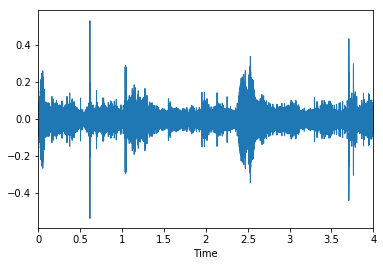

In [0]:
import librosa.display
librosa.display.waveplot(data, sr=sampling_rate)

Class:  3


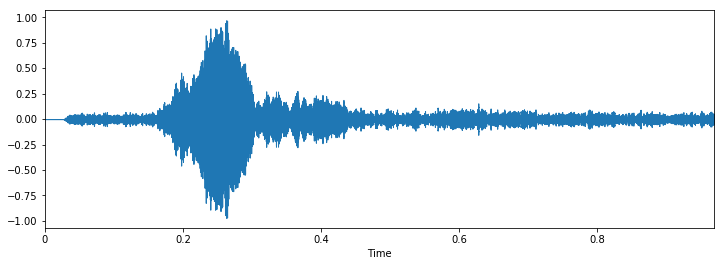

In [0]:
i = random.choice(train.index)

audio_name = train.ID[i]
path = os.path.join('content', 'Train', str(audio_name) + '.wav')

print('Class: ', train.Class[i])
x, sr = librosa.load('/content/Train/' + str(train.ID[i]) + '.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr)

In [0]:
train.Class.value_counts(normalize=True)

7    0.122907
5    0.114811
8    0.111684
3    0.110396
2    0.110396
9    0.110396
4    0.110396
0    0.110396
1    0.056302
6    0.042318
Name: Class, dtype: float64

There does not seem to be a significantly huge  class imbalance.

Now , I will try and extract the Mel-Frequency Ceptral Coefficients. These are one of the best forms of image representations of audio

In [0]:
max_pad = 174
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
    
    return mfccs

In [0]:
#data = '/content/Train'


features = []

# Iterate through each sound file and extract the features 
for index, row in train.iterrows():
    
    file_name = os.path.join(os.path.abspath("/content/Train"), str(row["ID"]) + ".wav")
    
    class_label = row["Class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  5435  files


In [0]:
features_test = []

# Iterate through each sound file and extract the features 
for index, row in test.iterrows():
    
    file_name = os.path.join(os.path.abspath("/content/Test"), str(row["ID"]) + ".wav")
    
    data = extract_features(file_name)
    
    features_test.append([data])

# Convert into a Panda dataframe 
featuresdf_test = pd.DataFrame(features_test, columns=['feature'])

print('Finished feature extraction from ', len(featuresdf_test), ' files')

Finished feature extraction from  3297  files


In [0]:
featuresdf.head(1)

,feature,class_label
0,"[[-81.72737160934581, -75.7642309052978, -79.7...",8


In [0]:
featuresdf.to_csv("train_feat.csv", index=False)
featuresdf_test.to_csv("test_feat.csv", index=False)

In [0]:
from sklearn.utils import  class_weight

cw = class_weight.compute_class_weight('balanced', np.unique(featuresdf["class_label"]),
                                                               featuresdf["class_label"])

In [0]:
list(cw)

[0.9058333333333334,
 1.776143790849673,
 0.9058333333333334,
 0.9058333333333334,
 0.9058333333333334,
 0.8709935897435898,
 2.3630434782608694,
 0.813622754491018,
 0.8953871499176277,
 0.9058333333333334]

In [0]:
featuresdf.class_label.value_counts()

7    668
5    624
8    607
3    600
2    600
9    600
4    600
0    600
1    306
6    230
Name: class_label, dtype: int64

In [0]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
y = to_categorical(y)

In [0]:
X_test = np.array(featuresdf_test.feature.tolist())

In [0]:
from sklearn.model_selection import train_test_split 

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.125, random_state = 42)

In [0]:
num_rows = 40
num_columns = 174
num_channels = 1

In [0]:
from keras.utils import Sequence 
import keras
from sklearn.preprocessing import normalize

In [0]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X_path,y, batch_size=10):
        'Initialization'
        self.batch_size = batch_size
        self.X_path = X_path
        self.y = y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X_path) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        X_path_batch = self.X_path[index*self.batch_size:(index+1)*self.batch_size]
        y_batch = self.y[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X = []
        y = []
        for x_p,y_p in zip(X_path_batch,y_batch):
            y.append(y_p)
            x_p = x_p.reshape(num_rows, num_columns, num_channels)
            X.append(x_p)
        X = np.array(X)
        y = np.array(y)
        return  X, y

In [0]:
training_generator = DataGenerator(x_train,y_train,batch_size=64)
validation_generator = DataGenerator(x_val,y_val,batch_size=64)

In [0]:
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K
from keras.layers.core import Dropout

In [0]:
class WideRN:
  def main_block(x, filters, n, strides, dropout):
    
	  # Normal part
	  x_res = Conv2D(filters, (3,3), strides=strides, padding="same")(x)
	  x_res = BatchNormalization()(x_res)
	  x_res = Activation('relu')(x_res)
	  x_res = Conv2D(filters, (3,3), padding="same")(x_res)
	  # Alternative branch
	  x = Conv2D(filters, (1,1), strides=strides)(x)
	  # Merge Branches
	  x = add([x_res, x])

	  for i in range(n-1):
		  # Residual conection
		  x_res = BatchNormalization()(x)
		  x_res = Activation('relu')(x_res)
		  x_res = Conv2D(filters, (3,3), padding="same")(x_res)
		  # Apply dropout if given
		  if dropout: x_res = Dropout(dropout)(x)
		  # Second part
		  x_res = BatchNormalization()(x_res)
		  x_res = Activation('relu')(x_res)
		  x_res = Conv2D(filters, (3,3), padding="same")(x_res)
		  # Merge branches
		  x = add([x, x_res])

	  # Inter block part
	  x = BatchNormalization()(x)
	  x = Activation('relu')(x)
	  return x
  
  @staticmethod
  def build(input_dims, output_dim, n, k, act= "relu", dropout=None):
    n = (n-4)//6
    # This returns a tensor input to the model
    inputs = Input(shape=(input_dims))

	  # Head of the model
    x = Conv2D(16, (3,3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # 3 Blocks (normal-residual)
    x = WideRN.main_block(x, 16*k, n, (1,1), dropout) # 0
    x = WideRN.main_block(x, 32*k, n, (2,2), dropout) # 1
    x = WideRN.main_block(x, 64*k, n, (2,2), dropout) # 2

    # Final part of the model
    x = AveragePooling2D((8,8))(x)
    x = Flatten()(x)
    x = Dense(output_dim)(x)
    outputs = Activation("softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [0]:
model = WideRN.build((40,174,1), 10, 22, 4)

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 174, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 174, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40, 174, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 40, 174, 16)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
model.compile(optimizer="adam" , loss="categorical_crossentropy", metrics=['accuracy'])

In [0]:
his = model.fit_generator(training_generator,
                    steps_per_epoch=len(x_train)//64,
                    epochs=40,
                    validation_data=validation_generator,
                   callbacks=[keras.callbacks.ModelCheckpoint(
                  'Model_wrn.val-acc={val_acc:.2f}.val-loss={val_loss:.2f}.h5',
                  monitor='val_loss',
                  verbose=0,
                  save_best_only=True,
                  save_weights_only=False,
                  mode='auto',
                  period=1
      )])

Epoch 1/40
74/74 [==============================] - 42s 567ms/step - loss: 1.2715 - acc: 0.5403 - val_loss: 3.2292 - val_acc: 0.4109
Epoch 2/40
74/74 [==============================] - 35s 476ms/step - loss: 0.7385 - acc: 0.7553 - val_loss: 4.7957 - val_acc: 0.3156
Epoch 3/40
74/74 [==============================] - 35s 478ms/step - loss: 0.5499 - acc: 0.8203 - val_loss: 3.5862 - val_acc: 0.4688
Epoch 4/40
74/74 [==============================] - 35s 474ms/step - loss: 0.4486 - acc: 0.8528 - val_loss: 2.9648 - val_acc: 0.4984
Epoch 5/40
74/74 [==============================] - 35s 477ms/step - loss: 0.3739 - acc: 0.8752 - val_loss: 1.1785 - val_acc: 0.6813
Epoch 6/40
74/74 [==============================] - 35s 475ms/step - loss: 0.2754 - acc: 0.9035 - val_loss: 1.3242 - val_acc: 0.7047
Epoch 7/40
74/74 [==============================] - 35s 475ms/step - loss: 0.2107 - acc: 0.9291 - val_loss: 1.2936 - val_acc: 0.6797
Epoch 8/40
74/74 [==============================] - 35s 476ms/step - 

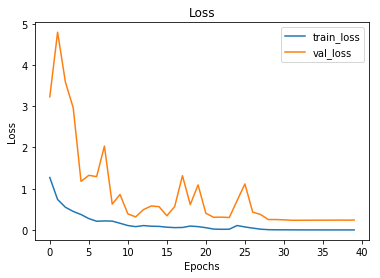

In [0]:
plt.plot(np.arange(0, 40), his.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), his.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")

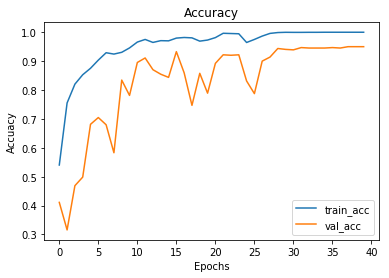

In [0]:
plt.plot(np.arange(0, 40), his.history["acc"], label="train_acc")
plt.plot(np.arange(0, 40), his.history["val_acc"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuacy")
plt.legend(loc="best")

Now, I need to do 2 things.
 
 * Scale the input matrices in the range  0 to 1
 * Calculate class_weights for training.

In [0]:
class NDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X_path,y, batch_size=10):
        'Initialization'
        self.batch_size = batch_size
        self.X_path = X_path
        self.y = y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X_path) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        X_path_batch = self.X_path[index*self.batch_size:(index+1)*self.batch_size]
        y_batch = self.y[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X = []
        y = []
        for x_p,y_p in zip(X_path_batch,y_batch):
            y.append(y_p)
            x_p = normalize(x_p)
            x_p = x_p.reshape(num_rows, num_columns, num_channels)
            X.append(x_p)
        X = np.array(X)
        y = np.array(y)
        return  X, y

In [0]:
training_generator = NDataGenerator(x_train,y_train,batch_size=64)
validation_generator = NDataGenerator(x_val,y_val,batch_size=64)

In [0]:
model2  =  WideRN.build((40,174,1), 10, 22, 4)

In [0]:
model2.compile(optimizer="adam" , loss="categorical_crossentropy", metrics=['accuracy'])

In [0]:
his2 = model2.fit_generator(training_generator,
                    steps_per_epoch=len(x_train)//64,
                    epochs=20,
                    validation_data=validation_generator,
                    class_weight = list(cw),
                   callbacks=[keras.callbacks.ModelCheckpoint(
                  'Model_wrn.val-acc={val_acc:.2f}.val-loss={val_loss:.2f}.h5',
                  monitor='val_loss',
                  verbose=0,
                  save_best_only=True,
                  save_weights_only=False,
                  mode='auto',
                  period=1
      )]) 

Epoch 1/20
74/74 [==============================] - 49s 658ms/step - loss: 1.6574 - acc: 0.4012 - val_loss: 5.9813 - val_acc: 0.1812
Epoch 2/20
74/74 [==============================] - 35s 476ms/step - loss: 1.0849 - acc: 0.6066 - val_loss: 4.6038 - val_acc: 0.2484
Epoch 3/20
74/74 [==============================] - 35s 478ms/step - loss: 0.8488 - acc: 0.6943 - val_loss: 7.1257 - val_acc: 0.2594
Epoch 4/20
74/74 [==============================] - 35s 477ms/step - loss: 0.6865 - acc: 0.7553 - val_loss: 5.0071 - val_acc: 0.3953
Epoch 5/20
74/74 [==============================] - 35s 476ms/step - loss: 0.5832 - acc: 0.7962 - val_loss: 1.2095 - val_acc: 0.6516
Epoch 6/20
74/74 [==============================] - 35s 477ms/step - loss: 0.4799 - acc: 0.8340 - val_loss: 1.4451 - val_acc: 0.6328
Epoch 7/20
74/74 [==============================] - 35s 477ms/step - loss: 0.4153 - acc: 0.8556 - val_loss: 4.2214 - val_acc: 0.4078
Epoch 8/20
74/74 [==============================] - 35s 477ms/step - 

In [0]:
his3 = model2.fit_generator(training_generator,
                    steps_per_epoch=len(x_train)//64,
                    epochs=40,
                    initial_epoch = 20,
                    validation_data=validation_generator,
                    class_weight = list(cw),
                   callbacks=[keras.callbacks.ModelCheckpoint(
                  'Model_wrn.val-acc={val_acc:.2f}.val-loss={val_loss:.2f}.h5',
                  monitor='val_loss',
                  verbose=0,
                  save_best_only=True,
                  save_weights_only=False,
                  mode='auto',
                  period=1
      )]) 

Epoch 21/40
74/74 [==============================] - 35s 473ms/step - loss: 0.0846 - acc: 0.9726 - val_loss: 1.3362 - val_acc: 0.7375
Epoch 22/40
74/74 [==============================] - 36s 480ms/step - loss: 0.0510 - acc: 0.9867 - val_loss: 1.5040 - val_acc: 0.7266
Epoch 23/40
74/74 [==============================] - 35s 477ms/step - loss: 0.0238 - acc: 0.9954 - val_loss: 1.0435 - val_acc: 0.7703
Epoch 24/40
74/74 [==============================] - 35s 478ms/step - loss: 0.0086 - acc: 0.9992 - val_loss: 0.4238 - val_acc: 0.8938
Epoch 25/40
74/74 [==============================] - 35s 478ms/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.3454 - val_acc: 0.9234
Epoch 26/40
74/74 [==============================] - 35s 477ms/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.3229 - val_acc: 0.9250
Epoch 27/40
74/74 [==============================] - 35s 479ms/step - loss: 9.5075e-04 - acc: 1.0000 - val_loss: 0.3278 - val_acc: 0.9266
Epoch 28/40
74/74 [==============================] - 35s 4

In [0]:
his2.history["loss"].extend(his3.history["loss"])
his2.history["loss"].extend(his3.history["loss"])

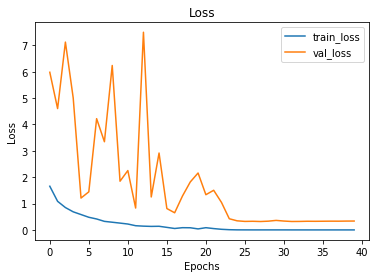

In [0]:
plt.plot(np.arange(0, 40), his2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), his2.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")

In [0]:
from keras.models import load_model

final_model = load_model("/content/Model_wrn.val-acc=0.93.val-loss=0.32.h5")

In [0]:
len(X_test)

3297

In [0]:
y_pred = []

for i in range(len(X_test)):
  p = normalize(X_test[i])
  p = p.reshape(num_rows, num_columns, num_channels)
  pred = final_model.predict(p[None, ...])
  pred = np.argmax(pred)
  y_pred.append(pred)

In [0]:
y_names = le.inverse_transform(y_pred)

In [0]:
test["Class"] = y_names

In [0]:
test.to_csv("UrbanSub1.csv", index=False)

In [0]:
y_pred = []

for i in range(len(X_test)):
  p = X_test[i]
  p = p.reshape(num_rows, num_columns, num_channels)
  pred = model.predict(p[None, ...])
  pred = np.argmax(pred)
  y_pred.append(pred)

In [0]:
y_names = le.inverse_transform(y_pred)

In [0]:
test["Class"] = y_names

In [0]:
test.to_csv("UrbanSub2.csv", index=False)